## CNN WITH CLASSES FROM [HERE](https://github.com/hunkim/DeepLearningZeroToAll/blob/master/lab-10-6-mnist_nn_batchnorm.ipynb)

In [1]:
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("CURRENT TF VERSION IS [%s]" % (tf.__version__))
print ("PACKAGES LOADED")

CURRENT TF VERSION IS [1.0.1]
PACKAGES LOADED


## DEFINE MODEL CLASS WITH TF.LAYERS

In [2]:
class Model:
    def __init__(self, name, input_dim, output_dim
                 , hidden_dims=[32, 32], use_batchnorm=True
                 , activation_fn=tf.nn.relu
                 , optimizer=tf.train.AdamOptimizer, lr=0.01):
        with tf.variable_scope(name):
            # SET PLACEHOLDERS
            self.x = tf.placeholder(tf.float32, [None, input_dim], name='X')
            self.y = tf.placeholder(tf.float32, [None, output_dim], name='Y')
            self.istrain = tf.placeholder(tf.bool, name='IS_TRAIN')
            # LOOP OVER HIDDEN LAYERS
            net = tf.reshape(self.x, [-1, 28, 28, 1])
            for i, h_dim in enumerate(hidden_dims):
                with tf.variable_scope('LAYER_{}'.format(i)):
                    # CONVOLUTION
                    net = tf.layers.conv2d(net, h_dim, (3, 3), padding='SAME')
                    # BATCH NORM
                    if use_batchnorm: 
                        net = tf.layers.batch_normalization(net, training=self.istrain)
                    # ACTIVATION (RELU)
                    net = activation_fn(net)
                    # MAX POOLING
                    net = tf.layers.max_pooling2d(inputs=net, pool_size=[2, 2], strides=2)
            # FINAL FULLY CONNECTED LAYER
            net = tf.contrib.layers.flatten(net)
            net = tf.layers.dense(net, output_dim)
            # DEFINE LOSS
            self.loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(
                    logits=net, labels=self.y), name='LOSS')    
            # DEFINE OPTIMIZER
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=name)
            with tf.control_dependencies(update_ops):                     
                self.optm = optimizer(lr).minimize(self.loss)
            
            # OTHERS
            softmax = tf.nn.softmax(net, name='SOFTMAX')
            self.corr = tf.equal(tf.argmax(softmax, 1), tf.argmax(self.y, 1))
            self.accr = tf.reduce_mean(tf.cast(self.corr, tf.float32))

## DEFINE SOLVER CLASS

In [3]:
class Solver:
    """
    # <EXAMPLE>
    bn = Model('batchnorm', input_dim, output_dim, use_batchnorm=True)
    sess = tf.InteractiveSession()
    solver = Solver(sess, model)
    # TRAIN
    solver.train(x, y)
    # EVALUATE
    solver.evaluate(x, y, _batch_size=128)
    """
    def __init__(self, _sess, _model):
        self.model = _model
        self.sess = _sess
    # DEFINE TRAIN FUNCTION
    def train(self, _x, _y):
        feed = {
            self.model.x: _x,
            self.model.y: _y,
            self.model.istrain: True
        }
        optm = self.model.optm
        loss = self.model.loss
        return self.sess.run([optm, loss], feed_dict=feed)
    # DEFINE EVALUATE FUNCTION
    def evaluate(self, _x, _y, _batch_size=None):
        if _batch_size:
            N = _x.shape[0]
            total_loss = 0
            total_accr = 0
            for i in range(0, N, _batch_size):
                x_batch = _x[i:i+_batch_size] # DON'T WORRY ABOUT OUT OF INDEX
                y_batch = _y[i:i+_batch_size]
                feed = {
                    self.model.x: x_batch,
                    self.model.y: y_batch,
                    self.model.istrain: False
                }
                loss = self.model.loss
                accr = self.model.accr
                step_loss, step_accr = self.sess.run([loss, accr], feed_dict=feed)
                total_loss += step_loss * x_batch.shape[0]
                total_accr += step_accr * x_batch.shape[0]
            total_loss /= N
            total_accr /= N
            return total_loss, total_accr
        else:
            feed = {
                self.model.x: _x,
                self.model.y: _y,
                self.model.istrain: False
            }
            loss = self.model.loss            
            accr = self.model.accr
            return self.sess.run([loss, accr], feed_dict=feed)

## INSTANTIATE MODEL/SOLVER 

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
# CREATE TWO MODELS WITH AND WITHOUT BATCHNORM
input_dim  = 784
output_dim = 10
nchannels  = [64, 128]
bn = Model('BATCHNORM', input_dim, output_dim, hidden_dims=nchannels, use_batchnorm=True)
nn = Model('NO_NORM', input_dim, output_dim, hidden_dims=nchannels, use_batchnorm=False)
# CREATE TWO CORRESPONDING SOLVERS
bn_solver = Solver(sess, bn)
nn_solver = Solver(sess, nn)
print("MODELS AND SOLVERS READY")

MODELS AND SOLVERS READY


## RUN

In [5]:
epoch_n    = 20
batch_size = 32
mnist      = input_data.read_data_sets("data/", one_hot=True)
tr_img     = mnist.train.images
tr_label   = mnist.train.labels
val_img    = mnist.validation.images
val_label  = mnist.validation.labels

# SAVE LOSSES AND ACCURACIES
tr_losses  = []
tr_accrs   = []
val_losses = []
val_accrs  = []
# INITALIZE
sess.run(tf.global_variables_initializer())
# OPTIMIZE
for epoch in range(epoch_n):
    # OPTIMIZE
    for _ in range(mnist.train.num_examples//batch_size):
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        _, bn_loss = bn_solver.train(X_batch, y_batch)
        _, nn_loss = nn_solver.train(X_batch, y_batch)       
    # COMPUTE TRAIN LOSSES AND ACCUARACIES
    b_train_loss, b_train_accr = bn_solver.evaluate(tr_img, tr_label, batch_size)
    n_train_loss, n_train_accr = nn_solver.evaluate(tr_img, tr_label, batch_size)
    # COMPUTE VALIDATION LOSSES AND ACCUARACIES
    b_val_loss, b_val_accr = bn_solver.evaluate(val_img, val_label)
    n_val_loss, n_val_accr = nn_solver.evaluate(val_img, val_label)
    # SAVE THEM
    tr_losses.append([b_train_loss, n_train_loss])
    tr_accrs.append([b_train_accr, n_train_accr])
    val_losses.append([b_val_loss, n_val_loss])
    val_accrs.append([b_val_accr, n_val_accr])
    # PRINT
    print ("[%d/%d] [TRAIN] BATCHNORM: %.4f (%.4f) vs. NO-NORM: %.4f (%.4f)" 
           % (epoch, epoch_n, b_train_loss, b_train_accr, n_train_loss, n_train_accr))
    print ("  [VALIDATION] BATCHNORM: %.4f (%.4f) vs. NO-NORM: %.4f (%.4f)" 
           % (b_val_loss, b_val_accr, n_val_loss, n_val_accr))
print ("OPTIMIZATION FINISHED")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
[0/20] [TRAIN] BATCHNORM: 0.1603 (0.9501) vs. NO-NORM: 0.0969 (0.9694)
  [VALIDATION] BATCHNORM: 0.1567 (0.9546) vs. NO-NORM: 0.0992 (0.9692)
[1/20] [TRAIN] BATCHNORM: 0.0388 (0.9873) vs. NO-NORM: 0.0415 (0.9865)
  [VALIDATION] BATCHNORM: 0.0536 (0.9834) vs. NO-NORM: 0.0524 (0.9840)
[2/20] [TRAIN] BATCHNORM: 0.0677 (0.9792) vs. NO-NORM: 0.0447 (0.9859)
  [VALIDATION] BATCHNORM: 0.0924 (0.9740) vs. NO-NORM: 0.0676 (0.9824)
[3/20] [TRAIN] BATCHNORM: 0.0371 (0.9881) vs. NO-NORM: 0.0690 (0.9808)
  [VALIDATION] BATCHNORM: 0.0624 (0.9828) vs. NO-NORM: 0.1024 (0.9762)
[4/20] [TRAIN] BATCHNORM: 0.0240 (0.9922) vs. NO-NORM: 0.0461 (0.9857)
  [VALIDATION] BATCHNORM: 0.0435 (0.9866) vs. NO-NORM: 0.0759 (0.9792)
[5/20] [TRAIN] BATCHNORM: 0.0221 (0.9928) vs. NO-NORM: 0.0329 (0.9895)
  [VALIDATION] BATCHNORM: 0.0463 (0.9886) vs. NO-

## COMPUTE TEST ACCURACY

In [6]:
b_test_loss, b_test_accr = bn_solver.evaluate(mnist.test.images, mnist.test.labels)
n_test_loss, n_test_accr = nn_solver.evaluate(mnist.test.images, mnist.test.labels)
print ("[TEST] BATCHNORM: %.4f (%.4f) vs. NO-NORM: %.4f (%.4f)"
      % (b_test_loss, b_test_accr, n_test_loss, n_test_accr))

[TEST] BATCHNORM: 0.0733 (0.9911) vs. NO-NORM: 0.2858 (0.9843)


## PLOT COMPARISON

In [7]:
def plot_comp(val_list, ylim=None, title=None, loc=None):
    bn = [i[0] for i in val_list]
    nn = [i[1] for i in val_list]
    plt.figure(figsize=(8, 5))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)
    if title:
        plt.title(title)
    plt.legend(loc=loc)
    plt.grid('on')
    plt.show()

## LOSSES

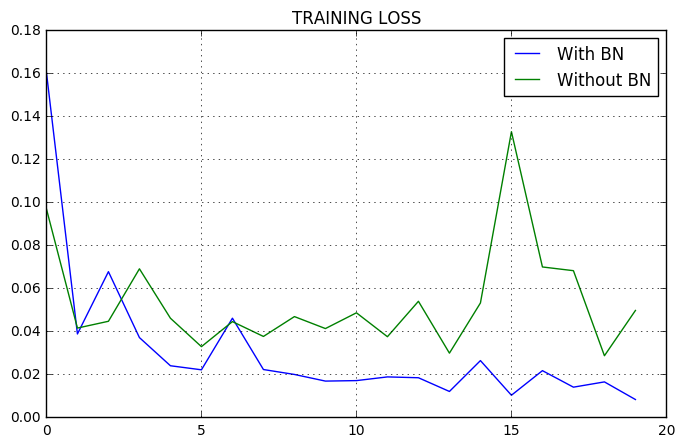

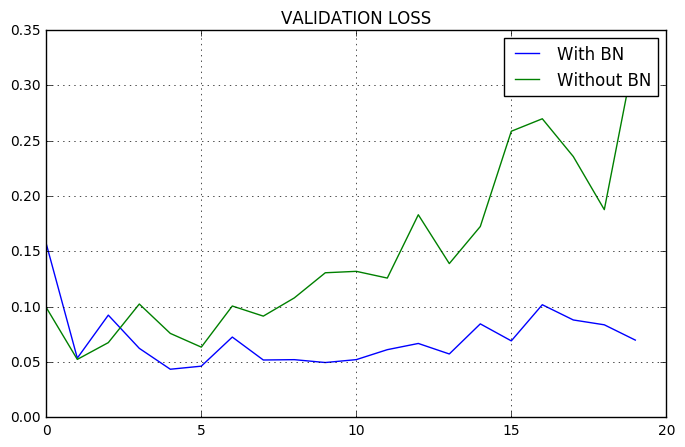

In [8]:
plot_comp(tr_losses, title="TRAINING LOSS")
plot_comp(val_losses, title="VALIDATION LOSS")

## ACCURACY

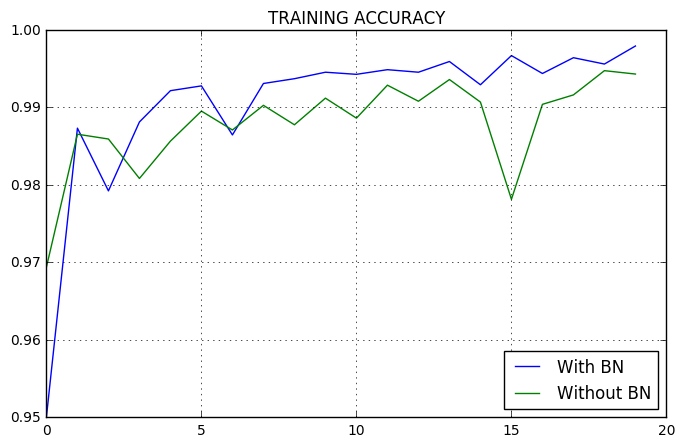

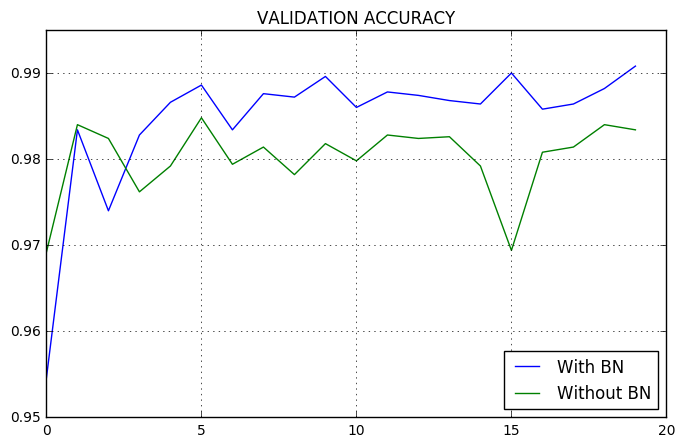

In [9]:
plot_comp(tr_accrs, title="TRAINING ACCURACY", loc=4)
plot_comp(val_accrs, title="VALIDATION ACCURACY", loc=4)